In [1]:
import os, time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from six import BytesIO
import numpy as np
import pandas as pd
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#image helper functions
def get_image_file_path(image_file_name):
    """returns the path of image file"""
    return 'C:/Users/HP/Desktop/Images' + image_file_name

def get_images(n):
    all_image_files = os.listdir("C:/Users/HP/Desktop/Images")
    # let's save all these image paths for later
    image_paths = list(map(get_image_file_path, all_image_files))
    # rather than using all, we will use a subset of these image paths for working on our model
    #image_paths = image_paths[:n]
    return image_paths

def get_image_id_from_path(image_path):
    """returns image id from image path"""
    return image_path.split('C:/Users/HP/Desktop/Images')[1].split('.jpg')[0]

In [3]:
# quick sanity check
print(get_images(10))
print(get_image_id_from_path(get_images(1)[1]))

['C:/Users/HP/Desktop/Images00000b4dcff7f799.jpg', 'C:/Users/HP/Desktop/Images00001a21632de752.jpg', 'C:/Users/HP/Desktop/Images0000d67245642c5f.jpg', 'C:/Users/HP/Desktop/Images0001244aa8ed3099.jpg', 'C:/Users/HP/Desktop/Images000172d1dd1adce0.jpg', 'C:/Users/HP/Desktop/Images0001c8fbfb30d3a6.jpg', 'C:/Users/HP/Desktop/Images0001dd930912683d.jpg', 'C:/Users/HP/Desktop/Imagesimage1170x530cropped.jpg', 'C:/Users/HP/Desktop/Images_92729063_newairportroadnearhebbal.jpg']
00001a21632de752


In [4]:
# submission helper functions
def get_prediction_string(result):
    with tf.device('/device:GPU:0'):
        """from each result, generates the complete prediction string in the format {Label Confidence XMin YMin XMax YMax},{...} based on submission file."""
        prediction_strings = []
        for index, score in enumerate(result['detection_scores']):
            index = int(index)
            single_prediction_string = ""
            single_prediction_string += result['detection_class_names'][index].decode("utf-8") + " "  + str(score) + " "
            single_prediction_string += " ".join(str(x) for x in result['detection_boxes'][index])
            prediction_strings.append(single_prediction_string)

        prediction_string = " ".join(str(x) for x in prediction_strings)
        return prediction_string

def get_prediction_entry(filepath, result):
    return {
        "ImageID": get_image_id_from_path(filepath),
        "PredictionString": get_prediction_string(result)
    }

In [5]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [6]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
image_path = "C:/Users/HP/Desktop/Images/image1170x530cropped.jpg"


with tf.device('/device:GPU:0'):
    with tf.Graph().as_default():
        detector = hub.Module(module_handle)
        image_string_placeholder = tf.placeholder(tf.string)
        decoded_image = tf.image.decode_jpeg(image_string_placeholder)
        # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
        # of size 1 and type tf.float32.
        decoded_image_float = tf.image.convert_image_dtype(
            image=decoded_image, dtype=tf.float32)
        module_input = tf.expand_dims(decoded_image_float, 0)
        result = detector(module_input, as_dict=True)
        init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

        session = tf.Session()
        session.run(init_ops)

        # Load the downloaded and resized image and feed into the graph.
        with tf.gfile.Open(image_path, "rb") as binfile:
            image_string = binfile.read()

        result_out, image_out = session.run(
            [result, decoded_image],
            feed_dict={image_string_placeholder: image_string})
        print("Found %d objects." % len(result_out["detection_scores"]))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.


Font not found, using default font.


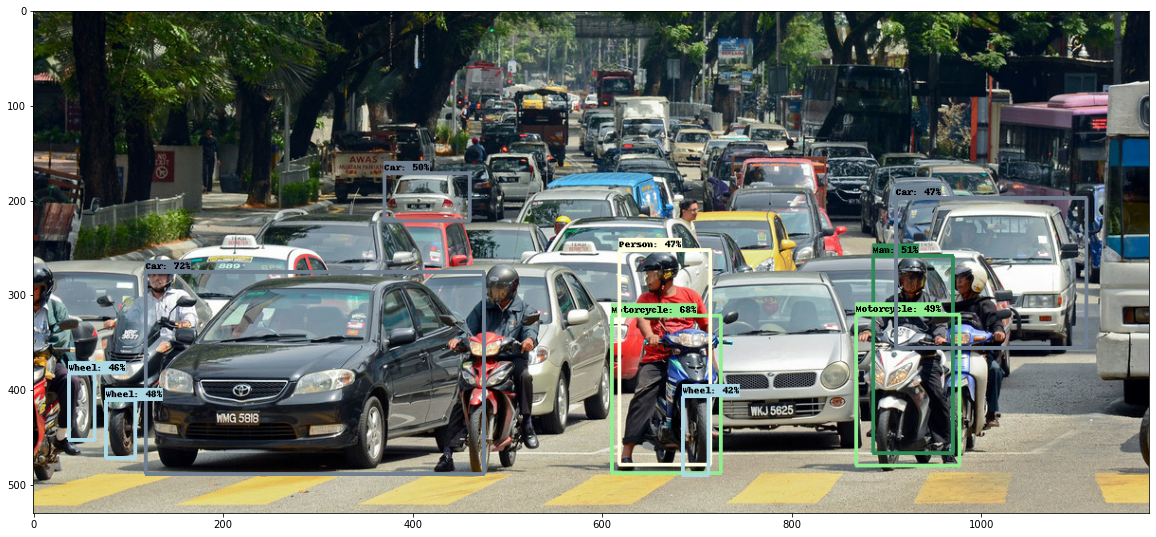

In [7]:
image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])
display_image(image_with_boxes)